<a href="https://www.kaggle.com/code/davidjohnmillard/tfwriter-rsna?scriptVersionId=119068308" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# RSNA TFWriter

The following is an approach to writing TFRecords to a Bucket in GCS.

# Imports/Setup

In [1]:
!pip install python-gdcm -q
!pip install pylibjpeg -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import os
import cv2
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
assert tf.__version__ >= "2.11"
from google.cloud import storage
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [3]:
tf.version.VERSION

'2.6.4'

In [4]:
path_test = '/kaggle/input/rsna-breast-cancer-detection/test.csv'
path_train = '/kaggle/input/rsna-breast-cancer-detection/train.csv'

In [5]:
dfte = pd.read_csv(path_test)
dftr = pd.read_csv(path_train)

# Handle the Data

First we need to split the training data into a training and validation set.

To get the image paths we can apply a function to the dataframe on each row to get the picture with patient_id and image_id.

Next we do some basic preproccessing to make sure each image is normalized.

In [6]:
def train_test_split(dataset):
    split = int(dataset.shape[0] * .8)
    return dataset[:split], dataset[split:]

In [7]:
def add_img_path_to_pd(row):
    return '/kaggle/input/rsna-breast-cancer-detection/train_images/' + str(row['patient_id']) + '/' + str(row['image_id']) + '.dcm'

# Image ROI

In [8]:
def crop_coords(img):
    """
    Crop ROI from image.
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)

Normalize the data and clip the data to inlcude only between 5 < x < 99 percentile of data.

In [9]:
def truncation_normalization(img):
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img, Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized

In [10]:
def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(img)
    return cl

def parse_clahe(image):
    cl1 = clahe(image, 1.0)
    cl2 = clahe(image, 2.0)
    img_final = cv2.merge((image, cl1, cl2))
    return img_final

In [11]:
def preprocess(imagepath, voi=False):
    IMG_SIZE = 512
    ds = pydicom.dcmread(imagepath)
    img = ds.pixel_array
    
    if voi:
        img = apply_voi_lut(img, ds)
    
    img_max = np.max(img)
    img = img / np.max(img)
    if ds.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
    img = img * img_max
    img = img[..., tf.newaxis]
    
    (x, y, w, h) = crop_coords(img.astype("uint8"))
    img_cropped = img[y:y+h, x:x+w]
    
    img_normalized = truncation_normalization(img_cropped)
                                              
    img_final = cv2.resize(img_normalized, (768, 1344))
    
    img_final = np.array(img_final*255, dtype=np.uint8)
    img_final = img_final[..., tf.newaxis]
    #img_final = cv2.equalizeHist(img_final)
    
    # img_final = parse_clahe(img_final)
                                              
    return img_final

In [12]:
dftr[dftr['cancer'] == 1]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False
190,1,10226,461614796,L,MLO,71.0,1,1,1,0.0,0,C,49,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,R,MLO,56.0,1,1,1,NaN,0,NaN,21,False
54593,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False
54594,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False
54595,2,9851,1409270544,L,MLO,58.0,1,1,0,NaN,0,NaN,48,False


In [13]:
data_augm_lay = keras.Sequential(
    [
        keras.layers.RandomZoom(height_factor=(0, -0.3))
    ]
)

2023-02-13 17:27:48.903946: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
def augment_image(image, y):
    
    image = tf.image.random_brightness(image, 0.10)
    # image = tf.image.random_contrast(image, 0.90, 1.40)
    # image = tf.image.random_saturation(image, 0.50, 2.00)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_jpeg_quality(image, 75, 100)
    
    image = data_augm_lay(image)
    
    # image = dropout(image)
    
    return image, y

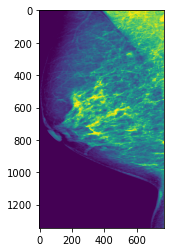

In [15]:
image1 = preprocess('/kaggle/input/rsna-breast-cancer-detection/train_images/9707/1900919592.dcm', voi=False)
plt.imshow(image1)

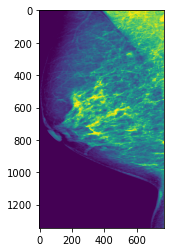

In [16]:
image2 = preprocess('/kaggle/input/rsna-breast-cancer-detection/train_images/9707/1900919592.dcm', voi=True)
plt.imshow(image2)

In [17]:
image1.dtype

dtype('uint8')

In [18]:
image3 = tf.io.encode_jpeg(image2)
image3 = tf.io.decode_jpeg(image3)

In [19]:
image3.shape

TensorShape([1344, 768, 1])

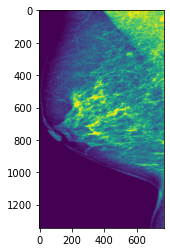

In [20]:
plt.imshow(image3)

In [21]:
# plt.imshow(augment_image(image2, 1)[0])

In [22]:
image2.shape

(1344, 768, 1)

# Useful Stats Writing Data

This is not a EDA Notebook book but we do need some useful statistics to deal with data.

In [23]:
def useful_stats():
    print('pos train %: ' + str(dftr[dftr['cancer'] == 1].shape[0] / dftr.shape[0] * 100))
    print('pos valid %: ' + str(dfv[dfv['cancer'] == 1].shape[0] / dfv.shape[0] * 100))

# Dealing With Files locally and in the Cloud

We need to follow the sequence: 
> write to local file -> push to cloud -> delete from local -> repeat

In [24]:
def push_to_cloud(filepath, bucket_name):
    print('pushing ' + filepath + ' to cloud in bucket: train_batches')
    
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(filepath)
    blob.upload_from_filename('/kaggle/working/' + filepath)

In [25]:
def delete_file(filepath):
    print('deleting ' + filepath + ' from local')
    os.remove('/kaggle/working/' + filepath)
    
def clear_all_local():
    for k in os.listdir('/kaggle/working/'):
        if k == '.virtual_documents':
            continue
        delete_file(k)

# Create an Example

Create an example using the features necessary to the Network.

In [26]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

def get_example(image, label, age, implant, laterality, view, diff_neg):
    return Example(
        features=Features(
            feature={
                'image': Feature(bytes_list=BytesList(value=[tf.io.encode_jpeg(image, optimize_size=True).numpy()])),
                'label': Feature(int64_list=Int64List(value=[label])),
                'age': Feature(int64_list=Int64List(value=[age])),
                'impant': Feature(int64_list=Int64List(value=[implant])),
                'laterality': Feature(bytes_list=BytesList(value=[laterality])),
                'view': Feature(bytes_list=BytesList(value=[view])),
                'diff_neg': Feature(int64_list=Int64List(value=[diff_neg]))
            }
        )
    )

# Write TFRecords

To write the files we need the dataset to read from, the name of the batches we are writing, and the bucket to write to.

The dataest is split into n batches and use offset incase connection is lost.

For every file in the n files created we create an example using the corresponding instance's values in the dataframe.

Finally the example is serialized and written it to the file.

This file is then pushed to gcs and deleted from the local system.

In [27]:
def write_tfrecords(name, dataset, bucket_name, n_shards, offset):
    paths = ["{}_batch_{:0>3}.tfrecord".format(name, index) for index in range(offset, n_shards)]
    
    for num, i in enumerate(paths):
        with tf.io.TFRecordWriter(i) as f: 
            print('writing to ' + i )
            for index, row in dataset[(num+offset)*(int(dataset.shape[0] / n_shards) + 1):(num+offset+1)*(int(dataset.shape[0] / n_shards) + 1)].iterrows():
                image = preprocess(row['imagepath'], voi=True)
                label = row['cancer']
                age = int(row['age'])
                implant = row['implant']
                laterality = bytes(row['laterality'], 'utf-8')
                view = bytes(row['view'], 'utf-8')
                diff_neg = 1 if row['difficult_negative_case'] else 0
                example = get_example(image, label, age, implant, laterality, view, diff_neg)
                f.write(example.SerializeToString())
                
        push_to_cloud(i, bucket_name)
        delete_file(i)
            
    return paths

# Define GCS Storage Area

In [28]:
client_area = 'kagglersna01'
storage_client = storage.Client(project=client_area)

# Apply Transformation to DataFrame

In [29]:
def setup_data(dirr, dataset):
    dataset.fillna(dataset['age'].median(), inplace=True)
    dataset['imagepath'] = dataset.apply(add_img_path_to_pd, axis=1)
    return train_test_split(dataset)
dftr, dfv = setup_data('train_images', dftr)

In [30]:
useful_stats()

pos train %: 2.0770496298327394
pos valid %: 2.2756351672454764


# Run TFRecord Writer

In [31]:
def main_run(name, dataset, bucket_name, n_shards=20, offset=0):
    clear_all_local()
    write_tfrecords(name, dataset, bucket_name, n_shards, offset)

In [32]:
BUCKET_NAME = 'train_batches'
main_run('train', dftr, BUCKET_NAME, n_shards=200, offset=136)
main_run('valid', dfv, BUCKET_NAME, n_shards=50, offset=0)

deleting __notebook__.ipynb from local
writing to train_batch_136.tfrecord
pushing train_batch_136.tfrecord to cloud in bucket: train_batches
deleting train_batch_136.tfrecord from local
writing to train_batch_137.tfrecord
pushing train_batch_137.tfrecord to cloud in bucket: train_batches
deleting train_batch_137.tfrecord from local
writing to train_batch_138.tfrecord
pushing train_batch_138.tfrecord to cloud in bucket: train_batches
deleting train_batch_138.tfrecord from local
writing to train_batch_139.tfrecord
pushing train_batch_139.tfrecord to cloud in bucket: train_batches
deleting train_batch_139.tfrecord from local
writing to train_batch_140.tfrecord
pushing train_batch_140.tfrecord to cloud in bucket: train_batches
deleting train_batch_140.tfrecord from local
writing to train_batch_141.tfrecord
pushing train_batch_141.tfrecord to cloud in bucket: train_batches
deleting train_batch_141.tfrecord from local
writing to train_batch_142.tfrecord
pushing train_batch_142.tfrecord to c

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


pushing valid_batch_042.tfrecord to cloud in bucket: train_batches
deleting valid_batch_042.tfrecord from local
writing to valid_batch_043.tfrecord
pushing valid_batch_043.tfrecord to cloud in bucket: train_batches
deleting valid_batch_043.tfrecord from local
writing to valid_batch_044.tfrecord
pushing valid_batch_044.tfrecord to cloud in bucket: train_batches
deleting valid_batch_044.tfrecord from local
writing to valid_batch_045.tfrecord
pushing valid_batch_045.tfrecord to cloud in bucket: train_batches
deleting valid_batch_045.tfrecord from local
writing to valid_batch_046.tfrecord
pushing valid_batch_046.tfrecord to cloud in bucket: train_batches
deleting valid_batch_046.tfrecord from local
writing to valid_batch_047.tfrecord
pushing valid_batch_047.tfrecord to cloud in bucket: train_batches
deleting valid_batch_047.tfrecord from local
writing to valid_batch_048.tfrecord
pushing valid_batch_048.tfrecord to cloud in bucket: train_batches
deleting valid_batch_048.tfrecord from local


# Parse an Example Instance

In [33]:
def parse_example(tfrecord):
    feature_desc = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=""),
        'label': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        'age': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        'impant': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        'laterality': tf.io.FixedLenFeature([], tf.string, default_value=""),
        'view': tf.io.FixedLenFeature([], tf.string, default_value=""),
        'diff_neg': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    example = tf.io.parse_single_example(tfrecord, feature_desc)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[1024, 1024, 3])
    return image, example["label"]

# Get Dataset From GCS Files

Create a tf.dataset from the file names in gcs.

We use multi-threading to speed up processing time.

We also shuffle the dataset to add more variablility. 

We call dataset.map() to parse each example in the file.

In [34]:
def record_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=500, n_parse_threads=5, batch_size=32):
    
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_example, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(32)
    
    return dataset.prefetch(1)

In [35]:
trainpaths = ['gs://' + BUCKET_NAME + '/' + "{}_batch_{}.tfrecord".format('train', index) for index in range(45)]
validpaths = ['gs://' + BUCKET_NAME + '/' + "{}_batch_{}.tfrecord".format('valid', index) for index in range(20)]

train_set = record_dataset(trainpaths)
valid_set = record_dataset(validpaths)